<a href="https://colab.research.google.com/github/hannape/CNN-second/blob/master/CNN_for_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
  # previous version, with hidden code and comments - cnn_scorer_not_working

from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function


**CNNy dla nowych danych:**

* jako testowe mamy te co wcześniej nagrania (6 nagrań z 2016), podzielone na 0,5sek fragmenty, z overlapem 150 ms bodajże. Całe nagrania podzielone, więc bardzo mało próbek pozytywnych będzie. 2,2% z głosami (676 bezwzględnie), sumarycznie 30813 rekordów
* jako trening - zbalansowany zbiór ~45 nagrań półgodzinnych. Nie jest idealnie 50:50, bo jeśli było w półgodzinnym nagraniu mniej niż 50 ramek z głosami (albo wcale), to i tak dokładałam 50 losowych ramek bez głosów (jest 45:55). Sumarycznie 17293 rekordów. 
* Na razie testowana reprezentacja 3 - mel spektrogram z pipeline'a birdvoxa - projektu o nocnych migrantach w hameryce. wygląda że działa?



**Pytania:**
* używam ważenia c_w = { 0:0.01, 1:0.99} - ma to sens? Karanie za 0, nagradzanie za 1
* po 50 epokach, model niezmieniany względem prób sprzed pół roku, AUC wychodzi rzędu 94-97% - jak to?... I nie wychodzą same zera, wręcz przeciwnie. Jest tu jakiś błąd czy po prostu jakimś cudem to po prostu działa?
* Chyba wartoby zrobić więcej danych testowych? Może jakieś inne? Na razie są te, by można było porównać z tym wszystkim co było robione poprzednio.




In [2]:
import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.utils import class_weight
from sklearn.metrics import  make_scorer
from sklearn.metrics import log_loss
K.set_image_dim_ordering('th')
import numpy as np
from sklearn import preprocessing
import glob
import os
import random
import functools
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#@title
source_repr = 'drive/My Drive/repr7/'
folder = ['repr7_2016/','repr7_2017/', 'repr7_2018/' ]
#X_train = numpy.load('drive/My Drive/X_train.npy')
#os.listdir("drive/My Drive/repr7")
records = os.listdir(source_repr + folder)
#for file in glob.glob("*.npz"):
#    print(file)
#content/drive/My Drive/repr7/repr7_2017
dane1 = np.load(source_repr + folder + records[2] )
r3 = dane1['rep3'] # mel-spectrogram birdvox
des = dane1['final_description']
print(np.shape(r3))
print((des[:,7]))
print(np.size(records))
print((records))



In [0]:
#@title
source_repr = 'drive/My Drive/repr7/'
folder = ['repr7_2017/', 'repr7_2018/', 'repr7_2016/' ]
folder = folder[2]
print(folder)
records = os.listdir(source_repr + folder)
test_set = ['BUK4_20160922_005604_7rep.npz','BUK4_20161008_004605_7rep.npz', 'BUK4_20161016_012704_7rep.npz','BUK4_20161016_035704_7rep.npz', 'BUK5_20161101_002104a_7rep.npz', 'BUK5_20161101_002104b_7rep.npz' ]
train_set = [x for x in records if x not in test_set]

print(type(records))
print(type(test_set))
print(np.shape(records))
print(np.shape(test_set))
#print(np.shape(l3))

dane2 = np.load(source_repr + folder_main[2] + 'BUK5_20161101_002104a_7rep.npz', allow_pickle=True )
print('Dostepne dane: ' + str(dane2.files))
#dane2['final_description']
des = dane2['final_description']
print(type(dane2['spec']))
print(np.shape(des[:,7]))
print((dane2['spec']))
print(np.zeros(shape=np.shape(dane2['spec'])))
print(type(str(np.zeros(shape=np.shape(dane2['spec'])))))
      
#y_train_spec = np.concatenate(dane2['spec'],dane2['spec'])

y_train_spec = np.concatenate((dane2['spec'],np.zeros(shape=np.shape(dane2['spec']))))
print(y_train_spec)
#print(np.zeros(shape=np.shape(dane2['spec'])))

In [0]:
#@title
## dane treningowe, wrzucanie jednego typu reprezenatacji do jednej macierzy

min_chunks = 50
source_repr = 'drive/My Drive/repr7/'
folder_main = [ 'repr7_2018/', 'repr7_2017/', 'repr7_2016/' ]
test_set = ['BUK4_20160922_005604','BUK4_20161008_004605', 'BUK4_20161016_012704','BUK4_20161016_035704', 'BUK5_20161101_002104a', 'BUK5_20161101_002104b' ]
repr_to_check = ['rep4']#['rep1','rep3', 'rep4', 'rep5'] #

for k in range(0, np.size(repr_to_check)):
  
  repr_nr = repr_to_check[k]
  print('-----------'+repr_nr+'-----------')
  
  # pierwsze dane, by mieć kształt macierzy i kolejno wcztywać następne
  records = os.listdir(source_repr + folder_main[0])
  dane1 = np.load(source_repr + folder_main[0] + records[0],allow_pickle=True )
  X_train= dane1[repr_nr]
  
  des = dane1['final_description']
  hasbird = des[:,7]
  y_train = hasbird
  #y_train_species = dane1['spec']
  if np.shape(dane1['spec'])[0]> min_chunks:
    y_train_species = np.concatenate((dane1['spec'],np.zeros(shape=np.shape(dane1['spec']))))
        
  else:
    y_train_species = np.concatenate((dane1['spec'],np.zeros(shape=(50,))))
  
  for j in range (0,np.size(folder_main)): # folder z latami

    folder = folder_main[j]
    print(folder)
    print(source_repr + folder)
    records = os.listdir(source_repr + folder)
    
    if j==2:
      records = [x for x in records if x not in test_set]
      print('2016!!!!!')

    #print(np.shape(records))

    for i in range (1,np.size(records)):  # nagrania w danym roku
      dane1 = np.load(source_repr + folder + records[i], allow_pickle=True )
      r3 = dane1[repr_nr]
      X_train = np.concatenate((X_train,r3))
      print(records[i])

      ## labels
      des = dane1['final_description']
      hasbird = des[:,7]
      y_train = np.concatenate((y_train,hasbird))
      if np.shape(dane1['spec'])[0]> min_chunks:
        species_rec = np.concatenate((dane1['spec'],np.zeros(shape=np.shape(dane1['spec']))))
        
      else:
        species_rec = np.concatenate((dane1['spec'],np.zeros(shape=(50,))))
      y_train_species = np.concatenate((y_train_species,species_rec))  
        
      #print(np.shape(y_train))
      #print(np.shape(y_train_species))
      #B_df = pd.read_csv('drive/My Drive/labele/labele_train/'+ nazwa_label)
      #y_train= np.concatenate((y_train,B_df.hasbird[0:500]))

  print(np.shape(X_train))
  print(np.shape(y_train))
  print(np.shape(y_train_species))
  np.save(('drive/My Drive/repr7/X_train_' + repr_nr), X_train)
  
np.save(('drive/My Drive/repr7/y_train' ), y_train)
np.save(('drive/My Drive/repr7/y_train_species'), y_train_species)
#print(np.size(y_train))

In [0]:
#@title
## dla danych testowych - było zrobione na ddrugim dysku, bo tam dane. 
## Dla testowych dużo większe, bo są całe nagrania

#min_chunks = 50
source_repr = 'drive/My Drive/'
folder_main = [ 'repr7_2016/' ]
test_set = ['BUK4_20160922_005604_7rep.npz','BUK4_20161008_004605_7rep.npz', 'BUK4_20161016_012704_7rep.npz','BUK4_20161016_035704_7rep.npz', 'BUK5_20161101_002104a_7rep.npz', 'BUK5_20161101_002104b_7rep.npz' ]
repr_to_check = ['rep1'] #,'rep3', 'rep4', 'rep5'] #

for k in range(0, np.size(repr_to_check)):
  
  repr_nr = repr_to_check[k]
  print('-----------'+repr_nr+'-----------')
  
  # pierwsze dane, by mieć kształt macierzy i kolejno wcztywać następne
  records = os.listdir(source_repr + folder_main[0])
  records = [x for x in records if x in test_set]

  dane1 = np.load(source_repr + folder_main[0] + records[0],allow_pickle=True )
  X_test= dane1[repr_nr]
  y_test = dane1['hasbird']
  y_test_species = dane1['species'] 
  print(records[0])
  print(np.shape(X_test))
  print(np.shape(y_test))
  print(np.shape(y_test_species))
  print(np.shape(dane1['species']))
  print('Dostepne dane: ' + str(dane1.files))
  
  for i in range (1,np.size(records)):
    print(records[i])
    dane1 = np.load(source_repr + folder_main[0] + records[i], allow_pickle=True )
    X_test = np.concatenate((X_test,dane1[repr_nr]))
    y_test = np.concatenate((y_test,dane1['hasbird']))
    #print(np.shape(y_test_species))
    
    print(np.shape(X_test))
    print(np.shape(y_test))
    a = dane1['species']
    print(len(a.shape))
    if (len(a.shape)==2):  # jeśli dwa wymiary
       a = np.squeeze(dane1['species'])  # to squeezujemy
  
    y_test_species = np.concatenate((y_test_species,a )) 
    print(np.shape(y_test_species))
  
  
  print(np.shape(X_test))
  print(np.shape(y_test))
  print(np.shape(y_test_species))
  np.save(('drive/My Drive/X_test_' + repr_nr), X_test)
  
np.save(('drive/My Drive/y_test' ), y_test)
np.save(('drive/My Drive/y_test_species'), y_test_species)

1


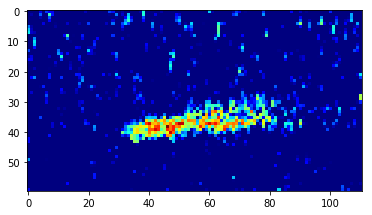

In [37]:
from numpy.random import seed
seed(667)
from tensorflow import set_random_seed
set_random_seed(667)
import random
random.seed()

## Reprezentacja 3 na razie sprawdzana  - czyli mel-spektrogram z birdvoxa, z zawężonym zakresem częstotliwości

X_train1 = numpy.load('drive/My Drive/repr7/X_train_rep3.npy', allow_pickle=True)
y_train1 = numpy.load('drive/My Drive/repr7/y_train.npy', allow_pickle=True)
X_test1 = numpy.load('drive/My Drive/repr7/X_test_rep3.npy', allow_pickle=True)
y_test1 = numpy.load('drive/My Drive/repr7/y_test.npy', allow_pickle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=667)
exemp = 4# exemplary frame
plt.imshow(X_val[exemp], cmap="jet")
print(y_val[exemp])
r = np.shape(X_val)[1]
s = np.shape(X_val)[2]

X_train = X_train.reshape(X_train.shape[0], 1, r, s).astype('float32')
X_val = X_val.reshape(X_val.shape[0], 1, r, s).astype('float32')
X_test = X_test1.reshape(X_test1.shape[0], 1, r, s).astype('float32')
y_test = np.squeeze(y_test1)
input_shape = (1, r, s)


In [0]:
#@title
print(np.shape(X_val)[2])
print(np.shape(X_val))
print(X_train.shape[0])
print(np.shape(y_test))

In [0]:
#@title
print(sum(y_train1))
print(np.shape(y_train1))
print(sum(y_train1/np.shape(y_train1)[0]))

print(sum(y_test))
print(np.shape(y_test))
print(sum(y_test/np.shape(y_test)[0]))

In [0]:
#@title
print(np.shape(X_val[2]))
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(np.squeeze(y_test))


In [0]:
c_w = { 0:0.01, 1:0.99}# { 0:0.02, 1:0.98}  # tak było, jeśli w trening wrzucamy całe nagranie. teraz mamy zbalansowany zbiór
index = ['r%d' % x for x in range(len(y_train))]
a = [c_w[class_label] for class_label in y_train]
sample_weight_frame = pd.DataFrame(a, index = index)
score_params = {"sample_weight": sample_weight_frame}
#print(sample_weight_frame[0:5])


In [0]:
# https://github.com/keras-team/keras/issues/2115

### SCORERS
import tensorflow as tf
import functools
from functools import partial, update_wrapper

def my_score(y_true, y_pred, sample_weight): 
  return log_loss(y_true.values, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1), normalize=True)

def wrapped_partial(func, *args, **kwargs):
	partial_func = partial(func, *args, **kwargs)
	update_wrapper(partial_func, func)
	return partial_func

def binary_crossentropy_weigted(y_true, y_pred, class_weights):
	y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
	loss = K.mean(class_weights*(-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred)),axis=-1)
	return loss

my_scorer = make_scorer(my_score,greater_is_better=False, needs_threshold=False,**score_params)  ## scoring for gridsearchCV
custom_loss = wrapped_partial(binary_crossentropy_weigted, class_weights=np.array([0.02, 0.98])) ## scoring for model.compile


## AUC METRIC
def as_keras_metric(method):
    import functools
    from keras import backend as K
    
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
  
auc_roc = as_keras_metric(tf.metrics.auc)


**BUILDING THE MODEL**

In [0]:
def make_model_modified(): #(dense_layer_sizes,filters, kernel_size,pool_size,lr, drop_out):
  
    dense_layer_sizes=128
    filters=10
    kernel_size=(3,3) #(3,3)
    pool_size= (2,2) 
    lr=0.0001 
    drop_out = 0.5
        
    model = Sequential()
    model.add(Conv2D(filters, kernel_size,input_shape=input_shape, activation='relu'))
   # model.add(Conv2D(16, (3, 3), input_shape=input_shape ))

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    
    model.add(Flatten())
    model.add(Dense(dense_layer_sizes, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=custom_loss,#'binary_crossentropy',#loss_2_args(y_true, y_pred)'',#loss='binary_crossentropy'
                  # co tu powinno wejść? o samo co do scoring w GridSearchCv? chyba nie: https://stackoverflow.com/questions/40572743/scikit-learn-grid-search-own-scoring-object-syntax
                  # my_score2(sample_weight = sample_weight_frame), <------------------- nie umiem zrobić by działał tutaj. Która funkcja? my_score czy my_scorer ?
                  # my_score2(sample_weight_frame) ---->  https://stackoverflow.com/questions/46858016/keras-custom-loss-function-to-pass-arguments-other-than-y-true-and-y-pred
                  # my_loss ---------------------------->też nie chodzi a chyba powinien, coś z formatem nie tak.  ERROR: 'Tensor' object has no attribute 'values'
                  # inne źródło: https://github.com/keras-team/keras/issues/2115
                  optimizer='adam',#keras.optimizers.Adam(lr),#'adam',
                  metrics=['accuracy',auc_roc])

    return model

**UKKYBIRDDET MODEL** // not here


In [0]:
#@title
#input_shape = (60, 87, 1)
from keras.layers import BatchNormalization, LeakyReLU
from keras.regularizers import l2

def make_model_ukybirddet():
    model = Sequential()
    # augmentation generator
    # code from baseline : "augment:Rotation|augment:Shift(low=-1,high=1,axis=3)"
    # keras augmentation:
    #preprocessing_function

    # convolution layers
    model.add(Conv2D(16, (3, 3), padding='valid', input_shape= input_shape ))
    model.add(BatchNormalization())  # explore order of Batchnorm and activation
    model.add(LeakyReLU(alpha=.001))
    model.add(MaxPooling2D(pool_size=(3, 3)))  # experiment with using smaller pooling along frequency axis
    model.add(Conv2D(16, (3, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=.001))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(16, (3, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=.001))
    model.add(MaxPooling2D(pool_size=(3, 1)))
    #model.add(Conv2D(16, (3, 3), padding='valid', kernel_regularizer=l2(0.01)))  # drfault 0.01. Try 0.001 and 0.001
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=.001))
    #model.add(MaxPooling2D(pool_size=(3, 1)))

    # dense layers
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=.001))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=.001))  # leaky relu value is very small experiment with bigger ones
    model.add(Dropout(0.5))  # experiment with removing this dropout
    model.add(Dense(1, activation='sigmoid'))
    
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

    # prepare callback
    #histories = my_callbacks.Histories()
    
    model.summary()  
    
    return model
  


**GRID SEARCH** // none here



In [0]:
#@title
my_classifier = KerasClassifier(make_model_modified)
validator = GridSearchCV(my_classifier,
                         param_grid={'dense_layer_sizes': [128],
                                     # epochs is avail for tuning even when not
                                     # an argument to model building function
                                     'epochs': [100], #[10,20,30],
                                     'filters': [10],
                                     'kernel_size': [(3,3)],
                                     'pool_size': [(2,2)],
                                     # 'class_weight': [{ 0:0.02, 1:0.98}],  <------------------------------- może w ten sposób? Ale t też tylko w grid searchu
                                     'batch_size': [32], 
                                     'drop_out':[0.5],#[0.2,0.5],
                                     'lr': [0.001]}, #[0.01,0.001,0.0001]},
                         scoring=my_scorer, n_jobs=1, refit=True, cv = 3)  ## SCORING ZMIENIONY na my_scorer (inne, np: 'roc_auc')

##https://stackoverflow.com/questions/49581104/sklearn-gridsearchcv-not-using-sample-weight-in-score-function

**CALLBACKS** // costamcostam


In [0]:
#@title
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.losses_val = []
        self.auc = []
        self.auc_val = []
        self.acc = []
        self.acc_val = []
        
        self.fig = plt.figure()        
        self.logs = []
        
        
    def on_epoch_begin(self, epoch, logs={}):
		    clear_output(wait=True);

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.losses_val.append(logs.get('val_loss'))
        self.auc.append(logs.get('auc'))
        self.i += 1
        plt.subplot(1, 2, 1)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.losses_val, label="val_loss")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.x, self.auc, label="auc")
        #plt.plot(self.x, self.auc_val, label="val_auc")
        print(self.x, self.auc)
        print(self.x, self.auc_val)
        plt.legend()
        
        #plt.subplot(1, 3, 3)  # nie działa :()
        #plt.plot(self.x, self.acc, label="acc")
        #plt.plot(self.x, self.acc_val, label="val_acc")
        #plt.legend()
        
        plt.show()
      
        
plot_losses = PlotLosses()

class Histories(keras.callbacks.Callback):
	def on_train_begin(self, logs={}):
		self.aucs = []
		self.losses = []

	def on_train_end(self, logs={}):
		return

	def on_epoch_begin(self, epoch, logs={}):
		return

	def on_epoch_end(self, epoch, logs={}):
		self.losses.append(logs.get('loss'))
		y_pred = self.model.predict(self.validation_data[0])
		self.aucs.append(roc_auc_score(self.validation_data[1], y_pred))
		a = (roc_auc_score(self.validation_data[1], y_pred))
		#print(" AUC_on_val: %f " % a)
		return

	def on_batch_begin(self, batch, logs={}):
		return

	def on_batch_end(self, batch, logs={}):    return
  
histories = Histories()

In [38]:
# dense_layer_sizes,filters, kernel_size,pool_size,lr, drop_out)
#my_classifier2 = KerasClassifier(make_model_modified(128,10,(3,3),(2,2),0.001,0.5))

#################################

repr_nr = '_rep3_'  
my_model = make_model_modified() #make_model_ukybirddet()

#################################
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler, CSVLogger
import math
import datetime
now = datetime.datetime.now()
start_time = str(now.year)+str('-')+str(now.month)+str('-')+str(now.day)+str('_')+str(now.hour+2)+str(':')+str(now.minute)

'''
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.1
	epochs_drop = 30.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	#print(lrate)
	return lrate

keras.callbacks.CSVLogger('', separator=',', append=False)

lrate = LearningRateScheduler(step_decay)
csv_logger = CSVLogger('drive/My Drive/przebiegi/training_150e_001_01_co30_3.log')
#es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=30, mode='max', baseline=None, restore_best_weights=True)
'''

y_frame = pd.DataFrame(y_train, index=index)

grid_result = my_model.fit(X_train, y_frame, batch_size = 32, epochs=100,validation_data=(X_val, y_val), verbose = 2) #, class_weight = c_w)


#grid_result = my_model.fit(X_train, y_frame, batch_size = 32, callbacks=[plot_losses, csv_logger, lrate, histories], epochs=150,validation_data=(X_val, y_val), verbose = 2) #, class_weight = c_w)
# [es, plot_losses, lrate, csv_logger, histories]
#my_model.save(('flmdl'+ repr_nr + start_time + '.h5'))
#print('Training done. The results are in : ')



Train on 13834 samples, validate on 3459 samples
Epoch 1/100
 - 4s - loss: 0.3386 - acc: 0.6796 - auc: 0.5810 - val_loss: 0.2085 - val_acc: 0.8462 - val_auc: 0.7414
Epoch 2/100
 - 4s - loss: 0.1885 - acc: 0.8533 - auc: 0.8026 - val_loss: 0.1691 - val_acc: 0.8676 - val_auc: 0.8370
Epoch 3/100
 - 4s - loss: 0.1600 - acc: 0.8774 - auc: 0.8569 - val_loss: 0.1436 - val_acc: 0.8948 - val_auc: 0.8722
Epoch 4/100
 - 3s - loss: 0.1503 - acc: 0.8876 - auc: 0.8827 - val_loss: 0.1467 - val_acc: 0.8922 - val_auc: 0.8900
Epoch 5/100
 - 3s - loss: 0.1424 - acc: 0.8928 - auc: 0.8962 - val_loss: 0.1504 - val_acc: 0.8858 - val_auc: 0.9008
Epoch 6/100
 - 4s - loss: 0.1353 - acc: 0.9014 - auc: 0.9049 - val_loss: 0.1332 - val_acc: 0.9052 - val_auc: 0.9090
Epoch 7/100
 - 3s - loss: 0.1289 - acc: 0.9041 - auc: 0.9123 - val_loss: 0.1304 - val_acc: 0.9075 - val_auc: 0.9152
Epoch 8/100
 - 3s - loss: 0.1257 - acc: 0.9076 - auc: 0.9180 - val_loss: 0.1343 - val_acc: 0.9008 - val_auc: 0.9201
Epoch 9/100
 - 3s - los

In [0]:
my_model.save(('drive/My Drive/models/flmdl'+ str(repr_nr) + str(start_time) + '.h5'))

In [115]:
#@title
#my_model.save('flmdl.h5')
#print('Training done. The results are in : ')
c = grid_result.history.keys()
print(grid_result.history.keys())
#grid_result = validator.fit(X_train, y_frame, callbacks=[es, plot_losses]) #, class_weight = c_w)

############


dict_keys(['val_loss', 'val_acc', 'val_auc', 'loss', 'acc', 'auc'])


CNN Error for val set: 9.51%
CNN Error for test set: 11.24%
(30813,)
(30813, 1)
AUC: 0.975


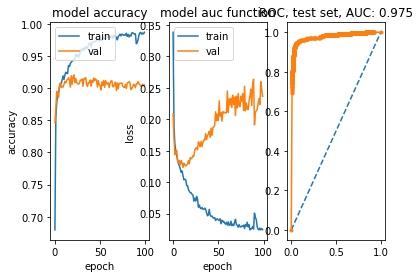

In [40]:
model = my_model
hist = grid_result
# Final evaluation of the model
scores_val = model.evaluate(X_val, y_val, verbose=0)
print("CNN Error for val set: %.2f%%" % (100-scores_val[1]*100))
scores_test = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error for test set: %.2f%%" % (100-scores_test[1]*100))

# summarize history for accuracy
plt.subplot(1, 3, 1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(1, 3, 2)

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model auc function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()

# calculate AUC of final model on a test set
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = y_test  # osobno, bo inny wymiar
print(np.shape(y_test2))
print(np.shape(probs))

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
plt.subplot(1, 3, 3)
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC, test set, AUC: %.3f' % auc)
pyplot.show()

In [0]:
#@title
# calculate AUC of final model on a test set
probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = numpy.load('drive/My Drive/y_test.npy')  # osobno, bo inny wymiar

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC curve for test set')
pyplot.show()

with open('drive/My Drive/ES_200e.txt', 'w') as f:
  print('Filename:', validator.best_params_, file=f)
  print('AUC on test set: %.3f' % auc)
  
from sklearn.externals import joblib
joblib.dump(grid_result.best_estimator_, 'model_200e.pkl')

(0.7, 1.05)

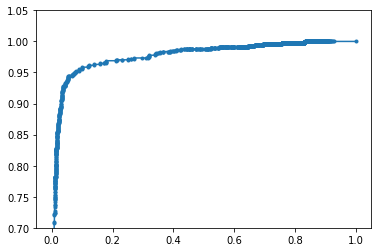

In [41]:
pyplot.plot(fpr, tpr, marker='.')
pyplot.ylim(bottom=0.7)


0.99712574
[[29228   909]
 [   66   610]]
              precision    recall  f1-score   support

     class 0       1.00      0.97      0.98     30137
     class 1       0.40      0.90      0.56       676

    accuracy                           0.97     30813
   macro avg       0.70      0.94      0.77     30813
weighted avg       0.98      0.97      0.97     30813



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.60, F = 0.56')

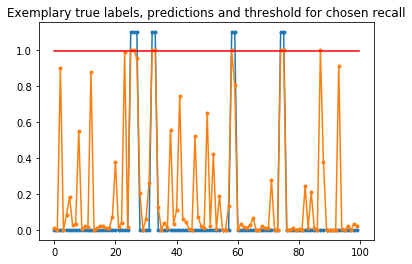

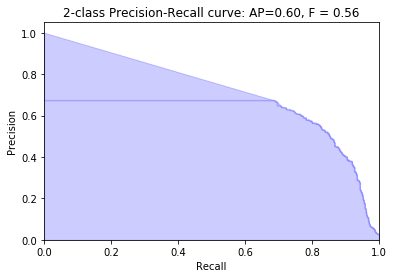

In [42]:
import sklearn.metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

start1 = 22800
end1 = 22900


index2 = ['r%d' % x for x in range(len(y_test))]
a2 = [c_w[class_label] for class_label in y_test]

#########
recall = 0.90
###########

a = (np.where(tpr>recall))
thr = thresholds[np.min(a)]  # do stworzenia confusion matrix bierzemy jakiś próg, np 90% wykrytych głosów
print(thr)
t2 = np.arange(0.0, end1-start1, 0.5)
plt.figure((1))
pyplot.plot(y_test2[start1:end1]*1.1, marker='.')
pyplot.plot(probs[start1:end1], marker='.')
pyplot.plot(t2, thr* np.ones(np.size(t2)), 'r-')
pyplot.title('Exemplary true labels, predictions and threshold for chosen recall')

probs_bool = probs>thr
probs_01 = [int(elem) for elem in probs>thr]
#cm = sklearn.metrics.confusion_matrix(y_test2, probs_01, labels=None, sample_weight=a2).ravel()
sklearn.metrics.confusion_matrix(y_test2, probs_01, labels=None, sample_weight=a2)
cm = sklearn.metrics.confusion_matrix(y_test2, probs_01)
print(cm)

target_names = ['class 0', 'class 1']
print(sklearn.metrics.classification_report(y_test2, probs_01, target_names=target_names))
f1 = sklearn.metrics.f1_score(y_test2, probs_01)
plt.figure(2)
precision, recall, _ = precision_recall_curve(y_test2, probs)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
average_precision = average_precision_score(y_test2, probs)

plt.title('2-class Precision-Recall curve: AP=%0.2f, F = %0.2f' %(average_precision,f1)) #{0:0.2f}

In [0]:
print(y_test2)

In [0]:
#@title
print('The parameters of the best model are: ')
print(validator.best_params_)

best_model = validator.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(X_test, y_test)
for metric, value in zip(metric_names, metric_values):
  print(metric, ': ', value)
  
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))
  
# calculate AUC of final model on a test set
probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = numpy.load('drive/My Drive/y_test.npy')  # osobno, bo inny wymiar

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC curve for test set')
pyplot.show()

with open('drive/My Drive/ES_200e.txt', 'w') as f:
  print('Filename:', validator.best_params_, file=f)
  print('AUC on test set: %.3f' % auc)
  
from sklearn.externals import joblib
joblib.dump(grid_result.best_estimator_, 'model_200e.pkl')
